Alan Vitullo 

© 2021

In [15]:
import os 
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

#
GENERATE_RES = 2
GENERATE_SQUARE = 32 * GENERATE_RES

IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100
SAVE_FREQ = 5

BATCH_SIZE = 32
BUFFER_SIZE = 64

EPOCHS = 100

In [10]:
import time
import numpy as np
from tqdm import tqdm
from PIL import Image

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

#
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.jpg")
  im = Image.fromarray(image_array)
  im.save(filename)

In [18]:
#Training Data Configuration
DATA_PATH = '/Users/adev/Documents/CE/source/anaconda/ml/plaid/'

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'face_images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training binary...")
  training_data = np.load(training_binary_path)

Looking for file: /Users/adev/Documents/CE/source/anaconda/ml/plaid/training_data_64_64.npy
Loading previous training binary...


In [19]:
import tensorflow as tf
print(tf.__version__)

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
import keras
import keras.applications as kapp
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.layers import Reshape, Conv2DTranspose, SeparableConv2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import UpSampling2D, BatchNormalization, Activation

# Optimizers
adam = Adam(0.0002, 0.5)
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
adelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

In [2]:
# Generator - 
def build_generator(seed_size):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(3,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [3]:
# Discriminator - 
def build_discriminator(img_shape):
    discriminator = Sequential()

    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    discriminator.add(BatchNormalization(momentum=0.8))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    #discriminator.summary()
    
    input_img = Input(shape=img_shape)
    
    validity = discriminator(input_img)
    
    return Model(input_img, validity)

In [11]:
# Compile Discriminator & Combined Models
image_shape = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
generator = build_generator(SEED_SIZE)

random_input = Input(shape=(SEED_SIZE,))

generated_image = generator(random_input)

discriminator.trainable = False

validity = discriminator(generated_image)

combined = Model(random_input, validity)
combined.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

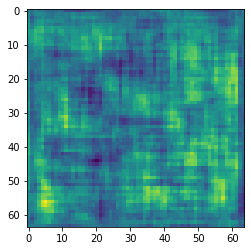

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

noise = np.random.random([1, 100])
gen_img = generator.predict(noise)

plt.imshow(gen_img[0, :, :, 0])

In [25]:
# Training
y_real = np.ones((BATCH_SIZE,1))
y_fake = np.zeros((BATCH_SIZE,1))

fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))

count = 1

for epoch in range(EPOCHS):
    index = np.random.randint(0, training_data.shape[0], BATCH_SIZE)
    x_real = training_data[index]
    
    seed = np.random.normal(0, 1, (BATCH_SIZE, SEED_SIZE))
    x_fake = generator.predict(seed)
    
    discriminator_metric_real = discriminator.train_on_batch(x_real, y_real)
    discriminator_metric_generated = discriminator.train_on_batch(x_fake, y_fake)
    discriminator_metric = 0.5 * np.add(discriminator_metric_real,discriminator_metric_generated)
    
    generator_metric = combined.train_on_batch(seed, y_real)
    
    if epoch % SAVE_FREQ == 0:
        save_images(count, fixed_seed)
        count += 1
        print(f'Epoch {epoch}, DA: {discriminator_metric[1]}), GA: {generator_metric[1]}')
    
generator.save(os.path.join(DATA_PATH, "face_generator.h5"))

INFO:plaidml:Analyzing Ops: 465 of 591 operations complete
INFO:plaidml:Analyzing Ops: 465 of 591 operations complete
INFO:plaidml:Analyzing Ops: 498 of 999 operations complete
INFO:plaidml:Analyzing Ops: 498 of 999 operations complete


Epoch 0, DA: 0.296875), GA: 0.78125
Epoch 5, DA: 0.46875), GA: 0.21875
Epoch 10, DA: 0.640625), GA: 0.28125
Epoch 15, DA: 0.765625), GA: 0.03125
Epoch 20, DA: 0.90625), GA: 0.0
Epoch 25, DA: 0.96875), GA: 0.03125
Epoch 30, DA: 0.90625), GA: 0.8125
Epoch 35, DA: 0.875), GA: 0.9375
Epoch 40, DA: 0.828125), GA: 0.0
Epoch 45, DA: 0.921875), GA: 0.09375
Epoch 50, DA: 0.953125), GA: 0.0625
Epoch 55, DA: 0.984375), GA: 0.0
Epoch 60, DA: 0.984375), GA: 0.0
Epoch 65, DA: 0.984375), GA: 0.0
Epoch 70, DA: 0.96875), GA: 0.0
Epoch 75, DA: 0.921875), GA: 0.0
Epoch 80, DA: 0.984375), GA: 0.0
Epoch 85, DA: 0.90625), GA: 0.0
Epoch 90, DA: 0.984375), GA: 0.0
Epoch 95, DA: 1.0), GA: 0.0


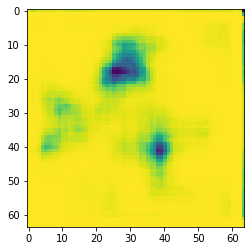

In [35]:
# 
noise = np.random.random([1, 100])
gen_img = generator.predict(noise)

plt.imshow(gen_img[0, :, :, 0])

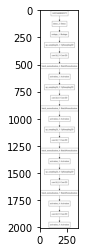

In [16]:
from keras.utils import plot_model

plot_model(generator, to_file='model.png')
img=mpimg.imread('model.png')
imgplot = plt.imshow(img)

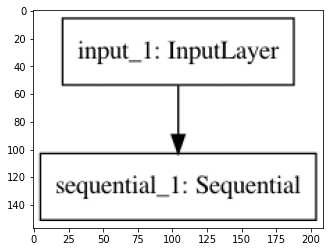

In [13]:
plot_model(discriminator, to_file='model.png')
img=mpimg.imread('model.png')
imgplot = plt.imshow(img)

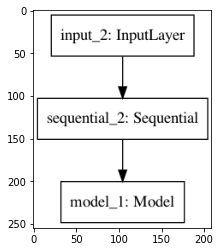

In [14]:
plot_model(combined, to_file='model.png')
img=mpimg.imread('model.png')
imgplot = plt.imshow(img)

In [8]:
def build_generator(seed_size):
    # generator
    generator = Sequential()

    gen_dense_nodes = 8*8*32

    #dense
    gen_layer1_dense = Dense(gen_dense_nodes, activation='relu', input_dim=seed_size)
    generator.add(gen_layer1_dense)

    #reshape
    gen_layer3_reshape = Reshape(((8, 8, 32)))
    generator.add(gen_layer3_reshape)
    print(generator.output_shape)

    #basic details
    gen_layer3_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer3_dc)
    print(generator.output_shape)
    gen_layer4_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer4_dc)
    print(generator.output_shape)
    gen_layer5_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer5_dc)
    print(generator.output_shape)

    #enlarge 1
    gen_layer6_dc = Conv2DTranspose(32, (5, 5), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer6_dc)
    print(generator.output_shape)
    gen_layer7_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=2, strides=1)
    generator.add(gen_layer7_dc)
    print(generator.output_shape)

    #inspection 1
    gen_layer8_conv2d = Conv2D(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer8_conv2d)
    print(generator.output_shape)

    #mid details
    gen_layer9_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer9_dc)
    print(generator.output_shape)
    gen_layer10_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer10_dc)
    print(generator.output_shape)

    #enlarge 2
    gen_layer11_dc = Conv2DTranspose(32, (5, 5), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer11_dc)
    print(generator.output_shape)
    gen_layer12_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=2, strides=1)
    generator.add(gen_layer12_dc)
    print(generator.output_shape)

    #inspection 2
    gen_layer13_conv2d = Conv2D(32, (3, 3), activation='relu')
    generator.add(gen_layer13_conv2d)
    print(generator.output_shape)

    #finer details
    gen_layer14_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer14_dc)
    print(generator.output_shape)
    gen_layer15_dc = Conv2DTranspose(32, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer15_dc)
    print(generator.output_shape)


    #output
    gen_layer19_dc = Conv2DTranspose(24, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer19_dc)
    print(generator.output_shape)
    gen_layer20_dc = Conv2DTranspose(8, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer20_dc)
    print(generator.output_shape)
    gen_layer21_dc = Conv2DTranspose(3, (3, 3), activation='relu', dilation_rate=1, strides=1)
    generator.add(gen_layer21_dc)
    print(generator.output_shape)

    #generator.summary()
    
    gen_input = Input(shape=(seed_size,))
    gen_img = generator(gen_input)
    
    return Model(gen_input,gen_img)